# ATREE_NOTMNIST

I am doing a train-test split here, since otherwise the structure of the tree will depend on the point being evaluated. However, in an active learning scenario we do not need to do this split and just need to subtract the label of the point.

## Conclusions...

KD-Trees work terribly when splits are done directly on high-dimensional data, so must use SVD first.

In [1]:
%load_ext autoreload
%autoreload 2

In [348]:
from collections import Counter

import scipy as sp
import scipy.io
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from kdtree import KDTree

The number of SVD components is in question.

In [332]:
INT2LABEL = np.array(list('ABCDEFGHIJ'))

data = sp.io.loadmat("notMNIST_small.mat")

images = data['images'].transpose(2, 0, 1)
samples = (2 * images.reshape(-1, 784) - 255.0) / 255.0

n_components = 50
samples = TruncatedSVD(n_components).fit_transform(samples)

labels = data['labels'].astype(int)
labels = INT2LABEL[labels]

trnI, devI, trnX, devX, trnY, devY = train_test_split(images, samples, labels, test_size=0.1)

In [335]:
tree = KDTree(trnX, trnY)

In [342]:
def get_pred(seq, conf=1.0, verbose=False):
    for n in seq[::-1]:
        cnts = n.label_cnts
        pred = max(list(INT2LABEL), key=lambda k: cnts[k])
        k = sum(cnts.values())
        eta = (cnts[pred] / k) - (1 / len(INT2LABEL))
        delta = conf / np.sqrt(k)
        if verbose:
            print('%s \t eta=%.3f \t delta=%.3f \t k=%d' % (pred, eta, delta, k))
        if eta >= delta:
            return pred

Actual point has label H


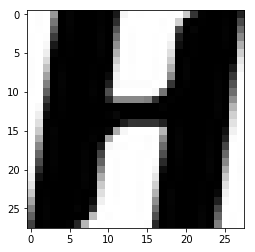

H 	 eta=0.567 	 delta=0.577 	 k=3
H 	 eta=0.650 	 delta=0.500 	 k=4


'H'

In [344]:
idx = np.random.randint(devY.size)
im, x, y = devI[idx], devX[idx], devY[idx]
print('Actual point has label %s' % y)
plt.imshow(im, cmap='Greys')
plt.show()

get_pred(tree.get_node_seq(x), verbose=True)

In [347]:
trees = [KDTree(trnX, trnY) for _ in range(20)]

In [351]:
res = []
for x, y in zip(devX, devY):
    preds = []
    for tree in trees:
        seq = tree.get_node_seq(x)
        preds.append(get_pred(seq, conf=1.0))
    pred = Counter(preds).most_common(1)[0][0]
    res.append(pred == y)
print('accuracy of atree rule is %.4f' % np.array(res).mean())

accuracy of atree rule is 0.8596
